In [ ]:
import re

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from wordcloud import WordCloud

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

###DATA LOADING

In [ ]:
data = pd.read_csv('/content/Corona_NLP_train.csv', encoding='latin-1')
test_data = pd.read_csv('/content/Corona_NLP_test.csv', encoding='latin-1')

In [ ]:
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
data.shape

(41157, 6)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [ ]:
data.isnull().sum()

,0
UserName,0
ScreenName,0
Location,8590
TweetAt,0
OriginalTweet,0
Sentiment,0


In [ ]:
data.duplicated().sum()

np.int64(0)

###DATA PREPROCESSING

In [ ]:
data['Location'].fillna('Unknown', inplace=True)

/tmp/ipython-input-3713988336.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Location'].fillna('Unknown', inplace=True)


In [ ]:
data.isnull().sum()

,0
UserName,0
ScreenName,0
Location,0
TweetAt,0
OriginalTweet,0
Sentiment,0


In [ ]:
# Const values that are going to be used many times

TARGET = 'Sentiment'
TARGET_CODE = 'SentimentCode'
TEXT = 'OriginalTweet'
PROCESSED = 'ProcessedText'

In [ ]:
data[TARGET] = data[TARGET].replace(['Extremely Positive', 'Extremely Negative'], ['Positive', 'Negative'])
test_data[TARGET] = test_data[TARGET].replace(['Extremely Positive', 'Extremely Negative'], ['Positive', 'Negative'])

In [ ]:
data[TARGET_CODE] = pd.Categorical(data[TARGET]).codes
test_data[TARGET_CODE] = pd.Categorical(test_data[TARGET]).codes

In [ ]:
class Preprocessor:
    def __init__(self, stopwords=stopwords):
        self.stoplist = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()

    @staticmethod
    def lower_texts(texts):
        print('Lowering...')
        return [text.lower() for text in tqdm(texts)]

    @staticmethod
    def remove_urls(texts):
        print('Removing URLs...')
        # Corrected pattern for URLs
        pattern = re.compile(r'https?://\S+|www\.\S+')
        return [re.sub(pattern, '', text) for text in tqdm(texts)]

    @staticmethod
    def remove_double_space(texts):
        print('Removing double space...')
        pattern = re.compile(' +')
        return [re.sub(pattern, ' ', text) for text in tqdm(texts)]

    @staticmethod
    def remove_punctuations(texts):
        print('Removing Punctuation...')
        pattern = re.compile('[^a-z ]')
        return [re.sub(pattern, ' ', text) for text in tqdm(texts)]

    @staticmethod
    def remove_html(texts):
        print('Removing HTML tags...')
        pattern = re.compile("<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>")
        return [re.sub(pattern, '', text) for text in tqdm(texts)]

    @staticmethod
    def remove_mentions(texts):
        print('Removing mentions...')
        pattern = re.compile('@[\w]+')
        return [re.sub(pattern, '', text) for text in tqdm(texts)]

    @staticmethod
    def remove_hashtags(texts):
        print('Removing hashtags...')
        pattern = re.compile('#\w+')
        return [re.sub(pattern, '', text) for text in tqdm(texts)]

    @staticmethod
    def remove_numbers(texts):
        print('Removing numbers...')
        return [' '.join([w for w in text if not w.isdigit()]) for text in tqdm(texts)]

    def remove_stopwords(self, texts):
        print('Removing stopwords...')
        return [[w for w in text.split(' ') if w not in self.stoplist] for text in tqdm(texts)]

    def lemmatize(self, texts):
        print('Lemmatizing...')
        return [self.lemmatizer.lemmatize(text) for text in tqdm(texts)]

    def transform(self, X):
        X = X.copy()
        X = X[~X.isnull()]                            # delete nans
        X = X[~X.duplicated()]                        # delete duplicates
        X = self.lower_texts(X)                       # lower texts
        X = self.remove_mentions(X)                   # remove mentions(@)
        X = self.remove_hashtags(X)                   # remove hashtags
        X = self.remove_urls(X)                       # remove urls
        X = self.remove_punctuations(X)               # remove punctuations
        X = self.remove_html(X)                       # remove html tags
        X = self.remove_double_space(X)               # remove double space
        X = self.remove_stopwords(X)                  # remove stopwords
        X = self.remove_numbers(X)                    # remove numbers
        X = self.lemmatize(X)                         # lemmatize


        return X

<>:39: SyntaxWarning: invalid escape sequence '\w'
<>:45: SyntaxWarning: invalid escape sequence '\w'
<>:39: SyntaxWarning: invalid escape sequence '\w'
<>:45: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipython-input-99488398.py:39: SyntaxWarning: invalid escape sequence '\w'
  pattern = re.compile('@[\w]+')
/tmp/ipython-input-99488398.py:45: SyntaxWarning: invalid escape sequence '\w'
  pattern = re.compile('#\w+')


In [ ]:
pr = Preprocessor()
data[PROCESSED] = pr.transform(data[TEXT])
test_data[PROCESSED] = pr.transform(test_data[TEXT])

Lowering...


100%|██████████| 41157/41157 [00:00<00:00, 865040.91it/s]


Removing mentions...


100%|██████████| 41157/41157 [00:00<00:00, 521051.76it/s]


Removing hashtags...


100%|██████████| 41157/41157 [00:00<00:00, 381855.36it/s]


Removing URLs...


100%|██████████| 41157/41157 [00:00<00:00, 243217.34it/s]


Removing Punctuation...


100%|██████████| 41157/41157 [00:00<00:00, 163368.36it/s]


Removing HTML tags...


100%|██████████| 41157/41157 [00:00<00:00, 583105.79it/s]


Removing double space...


100%|██████████| 41157/41157 [00:00<00:00, 85656.23it/s]


Removing stopwords...


100%|██████████| 41157/41157 [00:00<00:00, 99944.23it/s] 


Removing numbers...


100%|██████████| 41157/41157 [00:00<00:00, 636353.81it/s]


Lemmatizing...


100%|██████████| 41157/41157 [00:03<00:00, 12070.69it/s]


Lowering...


100%|██████████| 3798/3798 [00:00<00:00, 495303.98it/s]


Removing mentions...


100%|██████████| 3798/3798 [00:00<00:00, 409037.53it/s]


Removing hashtags...


100%|██████████| 3798/3798 [00:00<00:00, 290385.48it/s]


Removing URLs...


100%|██████████| 3798/3798 [00:00<00:00, 224688.52it/s]


Removing Punctuation...


100%|██████████| 3798/3798 [00:00<00:00, 110094.94it/s]


Removing HTML tags...


100%|██████████| 3798/3798 [00:00<00:00, 423117.92it/s]


Removing double space...


100%|██████████| 3798/3798 [00:00<00:00, 77093.42it/s]


Removing stopwords...


100%|██████████| 3798/3798 [00:00<00:00, 167475.84it/s]


Removing numbers...


100%|██████████| 3798/3798 [00:00<00:00, 442597.43it/s]

Lemmatizing...



100%|██████████| 3798/3798 [00:00<00:00, 237984.47it/s]


In [ ]:
data[[TEXT, TARGET, PROCESSED]]

,OriginalTweet,Sentiment,ProcessedText
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,
1,advice Talk to your neighbours family to excha...,Positive,advice talk neighbours family exchange phone n...
2,Coronavirus Australia: Woolworths to give elde...,Positive,coronavirus australia woolworths give elderly ...
3,My food stock is not the only one which is emp...,Positive,food stock one empty please panic enough food ...
4,"Me, ready to go at supermarket during the #COV...",Negative,ready go supermarket outbreak paranoid food st...
...,...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral,airline pilots offering stock supermarket shel...
41153,Response to complaint not provided citing COVI...,Negative,response complaint provided citing covid relat...
41154,You know itÂs getting tough when @KameronWild...,Positive,know getting tough rationing toilet paper mart...
41155,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong smell hand sanitizer starting turn


In [ ]:
# Drop rows with empty ProcessedText

indices = data[data[PROCESSED].str.strip() ==''].index
data.drop(indices, inplace=True)

indices = test_data[test_data[PROCESSED].str.strip()==''].index
test_data.drop(indices, inplace=True)

##**EDA**

In [ ]:
sns.set_style('darkgrid')

In [ ]:
def top_10_plot(df, text_col, regex, col_name, top_n=10, **kwargs):
    # Extract all matches into one flat list
    matches = df[text_col].dropna().apply(lambda x: re.findall(regex, str(x)))
    all_matches = [m for sublist in matches for m in sublist]

    # Count frequencies
    temp = pd.Series(all_matches).value_counts().head(top_n).reset_index()
    temp.columns = [col_name, 'count']

    # Sort order for seaborn (most frequent first)
    order = temp[col_name]

    palette = sns.color_palette("Spectral", n_colors=top_n)

    # Plot
    ax = sns.barplot(
        x=col_name,
        y='count',
        data=temp,
        order=order,
        palette=palette,
        **kwargs
    )
    ax.set_title(f'Top {top_n} {col_name}')
    return ax


/tmp/ipython-input-2879322645.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipython-input-2879322645.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


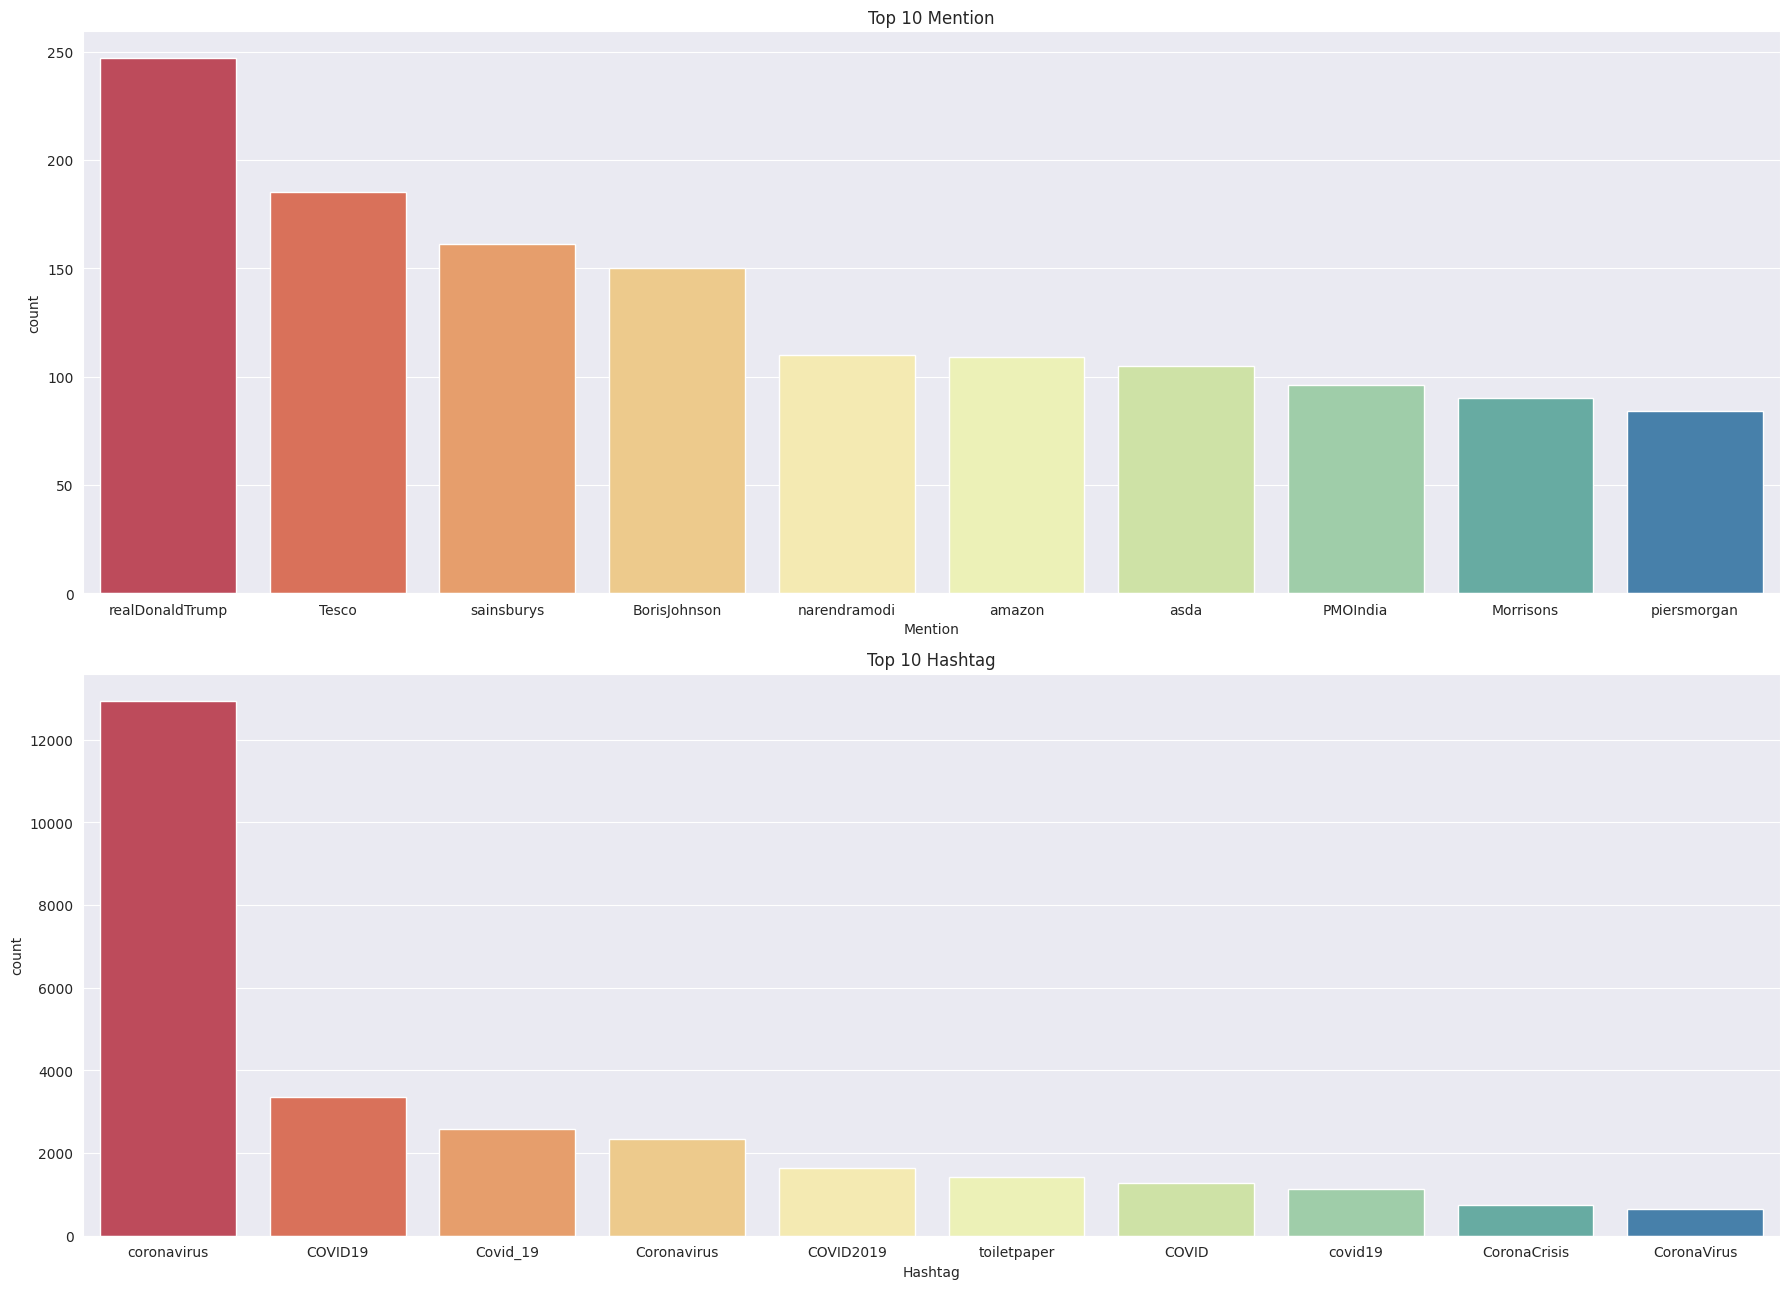

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(18,13))

# Top 10 mentions
top_10_plot(data, TEXT, r'(?<=@)\w+', 'Mention', ax=axes[0])

# Top 10 hashtags
top_10_plot(data, TEXT, r'(?<=#)\w+', 'Hashtag', ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
# sentiments of tweets distribution table

label_distribution = data.groupby(TARGET).count()[TEXT].reset_index().sort_values(by=TEXT, ascending=False)
label_distribution.style.background_gradient(cmap='winter')

,Sentiment,OriginalTweet
2,Positive,18044
0,Negative,15397
1,Neutral,7664


In [ ]:
# top10 locations of tweets distribution table

location_distribution = data.groupby('Location').count()[TEXT].reset_index().sort_values(by=TEXT, ascending=False)[:10]
location_distribution.style.background_gradient(cmap='autumn')

,Location,OriginalTweet
10472,Unknown,8577
5682,London,539
10440,United States,526
5757,"London, England",520
7082,"New York, NY",395
10778,"Washington, DC",373
10418,United Kingdom,337
5864,"Los Angeles, CA",281
4721,India,267
10268,UK,232


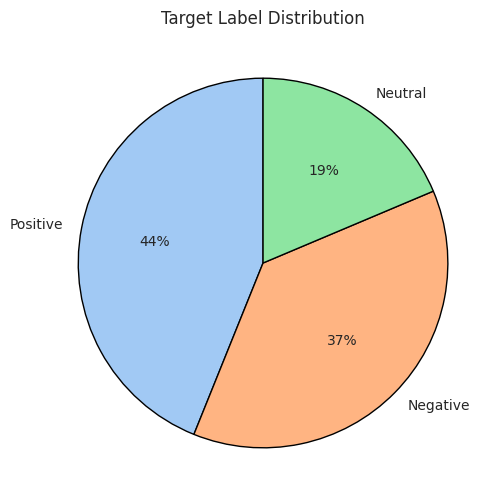

In [ ]:
# Pie chart for better understanding of each labels' portion

colors = sns.color_palette('pastel')
value_counts = data[TARGET].value_counts()
labels = label_distribution.Sentiment

# Create Pie Chart
plt.figure(figsize=(6,6))
plt.pie(
    value_counts,
    labels=labels,
    colors=colors,
    autopct='%.0f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'black'}
)
plt.title("Target Label Distribution")
plt.show()

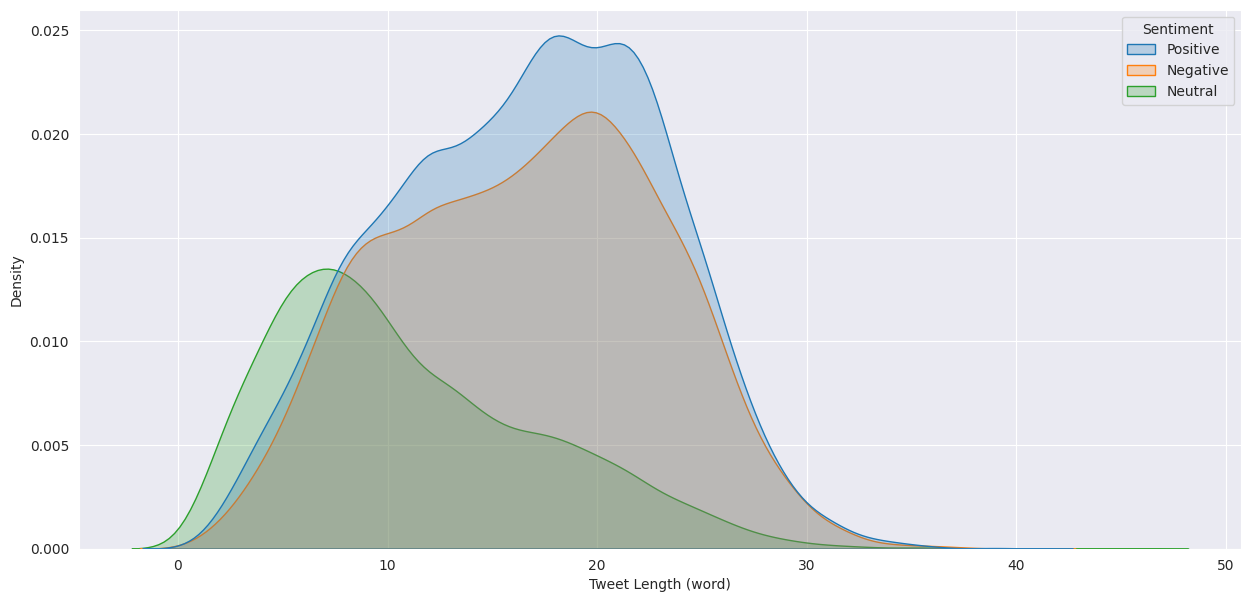

In [ ]:
tweets_len = pd.DataFrame(
    {
       'Tweet Length (word)': [len(text.split()) for text in data[PROCESSED]],
       'Sentiment': data[TARGET]
    }
)
plt.figure(figsize=(15, 7))
sns.kdeplot(data=tweets_len, x='Tweet Length (word)', hue='Sentiment', fill=True)
plt.show()

In [ ]:
word_counts = {label: [] for label in label_distribution.Sentiment}

for text, target in zip(data[PROCESSED], data[TARGET]):
    text = [word for word in text.split()]
    word_counts[target].extend(text)

/tmp/ipython-input-3546115332.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis, palette=palette)
/tmp/ipython-input-3546115332.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis, palette=palette)
/tmp/ipython-input-3546115332.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis, palette=palette)


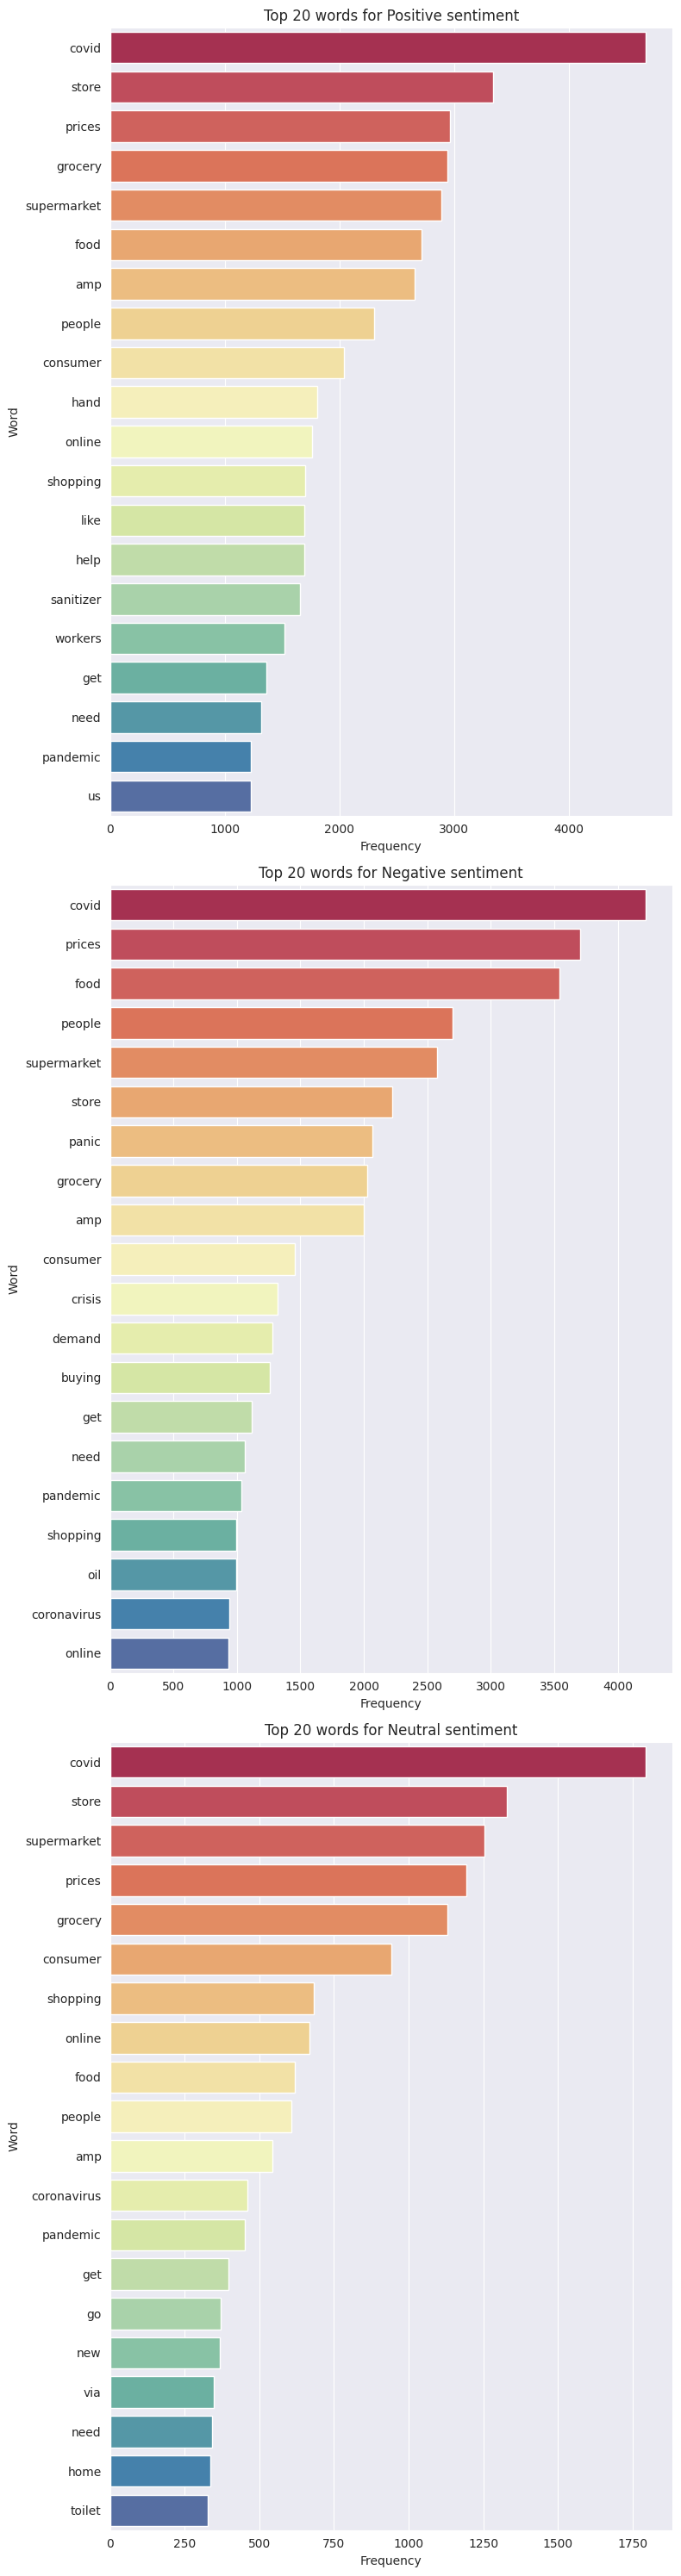

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 30))

for axis, (target, words) in zip(axes.flatten(), word_counts.items()):
    bar_info = pd.Series(words).value_counts()[:20]

    palette = sns.color_palette("Spectral", n_colors=len(bar_info))

    sns.barplot(x=bar_info.values, y=bar_info.index, ax=axis, palette=palette)


    axis.set_title(f'Top 20 words for {target} sentiment')
    axis.set_xlabel('Frequency')
    axis.set_ylabel('Word')

plt.tight_layout()
plt.show()

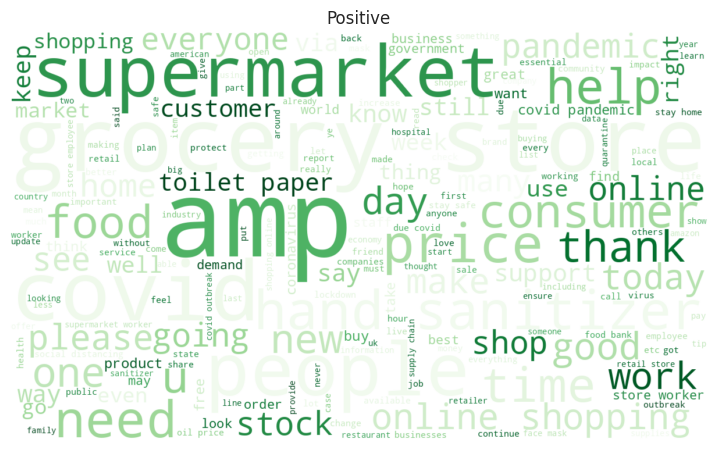

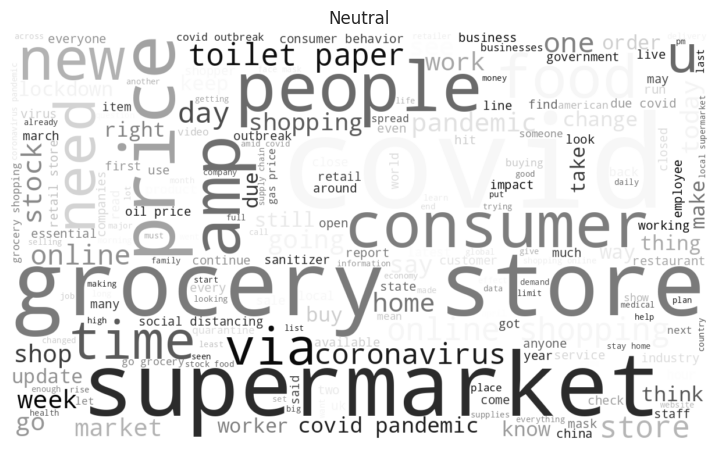

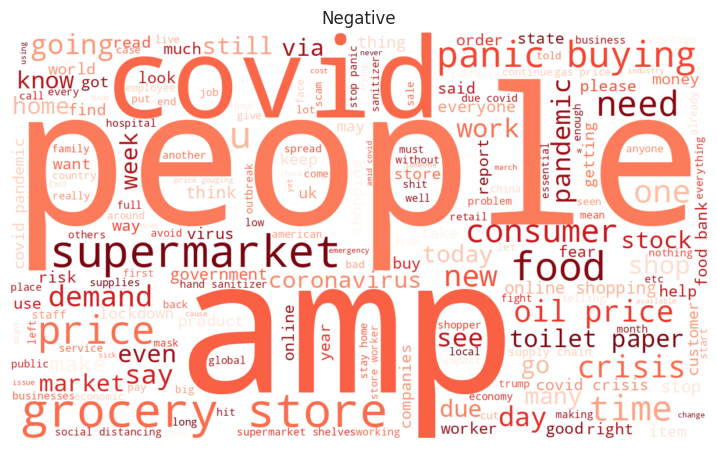

In [ ]:
labels = ['Positive', 'Neutral','Negative']
colormaps = ['Greens','Greys','Reds']

for label, colormap in zip(labels, colormaps):
    text = " ".join(word for word in data.loc[data[TARGET] == label, PROCESSED])
    wordcloud = WordCloud(
        width=1200,
        height=700,
        background_color="white",
        colormap=colormap,
        min_font_size=10
    ).generate(text)

    plt.figure(figsize=(9, 7), facecolor=None)
    plt.title(label)
    plt.axis("off")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.show()


## **DATA SPLIT**

In [ ]:
# split data into train/validation 90:10

np.random.seed(112)
df_train, df_val = np.split(data.sample(frac=1, random_state=42),
                                      [int(.9*len(data))])

# Reset the index after splitting
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)


print(f'Train Set Length: {len(df_train)}, Validation Set Length: {len(df_val)}')

Train Set Length: 36994, Validation Set Length: 4111


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
from torch.utils.data import Dataset
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class TextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=128):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = str(self.data.iloc[idx]['text'])    # column name with text
        label = int(self.data.iloc[idx]['label']) # column name with labels

        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),  # shape: [max_len]
            'attention_mask': encoding['attention_mask'].flatten()
        }, torch.tensor(label, dtype=torch.long)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## **CUSTOM DATASET**

In [ ]:
from transformers import BertTokenizer
import numpy as np
import torch

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = df[TARGET_CODE]
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        # Handle potential errors during tokenization and filter out problematic samples
        tokenized_texts = []
        valid_indices = []
        for i, text in enumerate(df[PROCESSED]):
            try:
                tokenized = self.tokenizer(text,
                                           padding='max_length', max_length=50, truncation=True,
                                           return_tensors="pt")
                tokenized_texts.append(tokenized)
                valid_indices.append(i)
            except IndexError:
                # Skip this sample if tokenization fails
                print(f"Skipping sample at index {i} due to tokenization error.")
                continue
            except ValueError as e:
                print(f"Skipping sample at index {i} due to ValueError: {e}")
                continue


        self.texts = tokenized_texts
        self.labels = self.labels.iloc[valid_indices].reset_index(drop=True)


    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels.iloc[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

## **MODEL**

In [ ]:
from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self, class_num):
        super(BertClassifier, self).__init__()
        self.class_num = class_num
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.fc = nn.Sequential(
            nn.Linear(768,512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(128, self.class_num),
        )

    def forward(self, input_ids, mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=mask, return_dict=False)
        out = self.fc(pooled_output)

        return out

In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score


def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=32, num_workers=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=32, num_workers=2, shuffle=True)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader, desc='Training...'):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_ids = train_input['input_ids'].squeeze(1).to(device)

                # Check for invalid token IDs and replace them
                vocab_size = model.bert.config.vocab_size
                input_ids[input_ids >= vocab_size] = tokenizer.unk_token_id # Replace out-of-vocab tokens with UNK token ID

                output = model(input_ids, mask)

                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0
            all_preds = []
            all_labels = []

            model.eval()
            with torch.no_grad():

                for val_input, val_label in tqdm(val_dataloader, desc='Validating...'):

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_ids = val_input['input_ids'].squeeze(1).to(device)

                    # Check for invalid token IDs and replace them
                    vocab_size = model.bert.config.vocab_size
                    input_ids[input_ids >= vocab_size] = tokenizer.unk_token_id # Replace out-of-vocab tokens with UNK token ID


                    output = model(input_ids, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

                    # store preds & labels for metrics
                    preds = output.argmax(dim=1).cpu().numpy()
                    labels = val_label.cpu().numpy()

                    all_preds.extend(preds)
                    all_labels.extend(labels)


            print(f"\nEpoch {epoch_num + 1}/{epochs}:")
            print(f"Train Loss: {total_loss_train / len(train_data): .3f}, Train Accuracy: {total_acc_train / len(train_data): .3f}")
            print(f"Validation Loss: {total_loss_val / len(val_data): .3f}, Validation Accuracy: {total_acc_val / len(val_data): .3f}")

            # Classification report & F1
            print("\nClassification Report:")
            print(classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"]))

            val_f1 = f1_score(all_labels, all_preds, average='weighted')
            val_precision = precision_score(all_labels, all_preds, average='weighted')
            val_recall = recall_score(all_labels, all_preds, average='weighted')

            print(f"F1 Score: {val_f1:.3f}, Precision: {val_precision:.3f}, Recall: {val_recall:.3f}")
            print('-'*40)


EPOCHS = 5
LR = 2e-5
model = BertClassifier(class_num=3)

train(model, df_train, df_val, LR, EPOCHS)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Training...:  20%|██        | 233/1157 [1:00:44<3:55:06, 15.27s/it]

##**TRAINING**

In [ ]:
print(df_train.columns)
print(df_train.head())


In [ ]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from torch.utils.data import DataLoader
from transformers import BertTokenizer

y_true_list = []
y_pred_list = []


def evaluate(model, test_data):

    test = Dataset(test_data) # Assuming Dataset class is defined elsewhere and can take a DataFrame
    test_dataloader = DataLoader(test, batch_size=32, num_workers=2, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    total_acc_test = 0
    y_true_list, y_pred_list = [], []

    with torch.no_grad():
        for test_input, test_label in tqdm(test_dataloader, desc='Testing...'):
            test_label = test_label.long().to(device) # Ensure label is long before moving to device

            mask = test_input['attention_mask'].to(device)
            input_ids = test_input['input_ids'].squeeze(1).to(device)

            # Check for invalid token IDs and replace them
            vocab_size = model.bert.config.vocab_size
            input_ids[input_ids >= vocab_size] = tokenizer.unk_token_id # Replace out-of-vocab tokens with UNK token ID

            output = model(input_ids, mask)
            _, predictions = torch.max(output, 1)

            acc = (predictions == test_label).sum().item()
            total_acc_test += acc

            y_true_list.extend(test_label.cpu().numpy())
            y_pred_list.extend(predictions.cpu().numpy())

    print(f"\nTest Accuracy: {(total_acc_test / len(test_data)) * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_true_list, y_pred_list, target_names=["Negative","Neutral","Positive"]))


    return y_true_list, y_pred_list

In [ ]:
test_acc, y_true, y_pred = evaluate(model, test_data)
print("Final Test Accuracy:", test_acc)





In [ ]:
print(test_data['SentimentCode'].unique())
print(test_data['SentimentCode'].dtype)

In [ ]:
print(test_data['SentimentCode'].unique())


In [ ]:
label = int(self.data.iloc[idx]['SentimentCode'])
return encoding, label


In [ ]:
device = torch.device("cpu")


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


print(confusion_matrix(y_true_list, y_pred_list))